In [1]:
import numpy as np
from scipy.signal import iirdesign
from scipy.signal import filtfilt
from scipy.signal import savgol_filter
import os
import numpy as np
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd



In [3]:
mat = scipy.io.loadmat('HPC_100_CH46.continuous.mat')
signal_HPC = mat['HPC'].squeeze()
print(signal_HPC.shape)

mat_pfc = scipy.io.loadmat("PFC_100_CH11.continuous.mat")
signal_PFC = mat_pfc["PFC"].squeeze()
print(signal_PFC.shape)

(6712704,)
(6712704,)


## EEG HPC & PFC

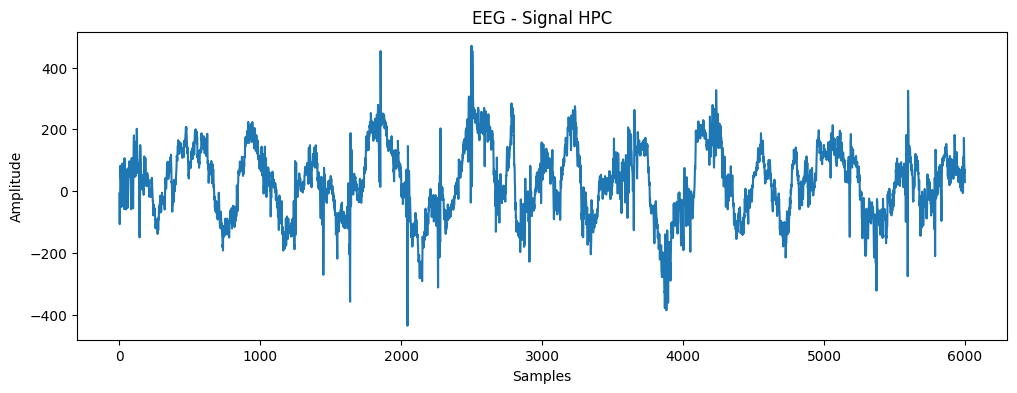

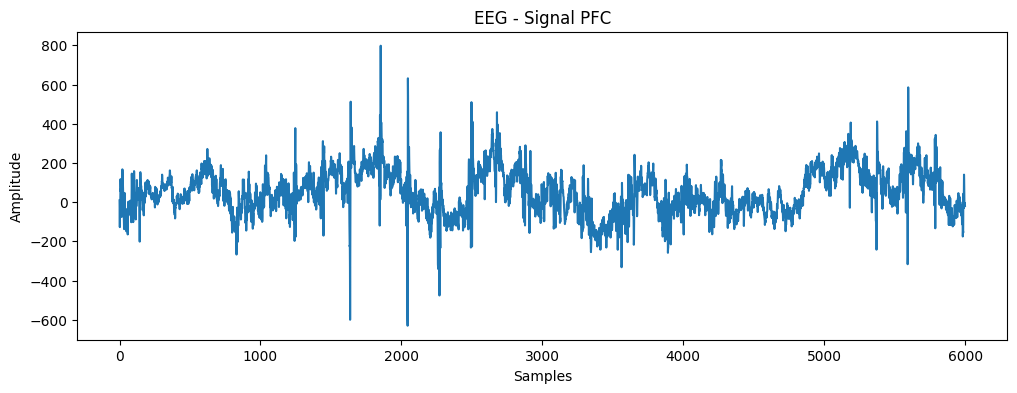

In [4]:
plt.figure(figsize=(12,4))
plt.plot(signal_HPC[:6000])   
plt.title("EEG - Signal HPC")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(signal_PFC[:6000])   
plt.title("EEG - Signal PFC")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

In [5]:
import numpy as np

def findIntervalsA(booString):
    """
    This function takes a boolean string and returns the start and end indices of consecutive True values.

    Parameters:
        booString (numpy array) : A boolean numpy array where True values indicate the presence of a condition.

    Returns:
        numpy array : A 2D numpy array where each row represents an interval of consecutive True values in the input. 
        The first column is the start index and the second column is the end index of the interval.

    Note:
    The function assumes that the input is a 1D boolean numpy array. If the input does not meet this assumption, the function may not work as expected.
    """
    booString = booString.reshape((1, len(booString)))

    starts = np.where(np.diff((np.concatenate(([False], booString[0]), axis=0)).astype(int)) > 0)[0]
    ends = np.where(np.diff((np.concatenate((booString[0], [False]), axis=0)).astype(int))< 0)[0]

    intervals = np.vstack((starts, ends)).T
    return intervals

def ConsolidateIntervalsFast(intervals, strict='off', epsilon=0):
    """
    Merge together the intervals that are overlapping.

    Parameters:
        intervals (list of tuples): List of intervals (e.g., [(start1, end1), (start2, end2), ...]).
        strict (str, optional): Intervals with common bounds are consolidated ('off') or kept separate ('on').
            Default is 'off'.
        epsilon (float, optional): Intervals with close enough bounds (distance lesser than epsilon) are also
            consolidated. Default is 0.

    Returns:
        list of tuples: Consolidated intervals.
        list of int: For each original interval, the index of the consolidated
            interval to which it belongs (empty intervals yield NaN).

    Note:
        Assumes the intervals are sorted in time and that no interval is completely contained within another.
    """
    if len(intervals) == 0:
        raise ValueError("Input list of intervals cannot be empty.")

    # Get difference between two consecutive intervals
    vector = np.array(intervals).flatten()
    d = np.diff(vector)
    d = d[1::2]

    # Define problematic spots
    if strict == 'on':
        problematic = d < epsilon
    else:
        problematic = d <= epsilon
    # Leave function if intervals don't need consolidating
    if not np.any(problematic):
        consolidated = intervals
        return consolidated

    # Mark already consolidated intervals
    problematic_etendu = np.concatenate(([False], problematic, [False]))
    done = [intervals[i] for i in range(len(intervals)) if not problematic_etendu[i] and not problematic_etendu[i+1]]


    # Initialize consolidated intervals and target list
    indices = toIntervals(problematic)
    for i in range(len(indices)):
      indices[i] = (indices[i][0], indices[i][1] + 1)
    fixed= [ (x, y) for x, y in zip([intervals[int(i) - 1][0] for i, _ in indices], [intervals[int(i) - 1][1] for _, i in indices]) ]
    #fixed = [tuple([intervals[int(i) - 1][0] for i, _ in indices], [intervals[int(i) - 1][1] for _, i in indices])]
    # Concatenate done and fixed vertically    
    if done != [] and fixed != []:
      consolidated = np.vstack((done, fixed))
    elif done == []:
       consolidated = [list(el) for el in fixed]
    else:
       consolidated = [list(el) for el in done]
    # Sort the rows of consolidated based on the first column
    consolidated = np.array(consolidated)

    # Sort the rows of consolidated based on the first column
    consolidated = consolidated[consolidated[:, 0].argsort()]
    consolidated = [tuple(row) for row in consolidated]
    target = [None] * len(intervals)
    # Initialize variables for the current interval
    current_start, current_end = intervals[0]
    current_target = 1

    # Convert target indices to 1-based indexing
    target = [t + 1 if t is not None else None for t in target]
    # Return the consolidated intervals
    return consolidated

def toIntervals(x, in_ = None):
    """
    Convert logical vector to a list of intervals.

    Parameters:
        x (list) : values, e.g. timestamps
        in_ (boolean list, optional) : boolean list of the same length as x;
    Returns:
        list : A list of tuples where each tuple represents an interval. Each tuple contains two elements: the start and end of the interval.

    Note:
    _in  can also be omitted, in which case x needs to be a boolean list
    and the intervals are defined in terms of indices in the logical vector.
    """
    if len(x) == 0:
        raise ValueError('Incorrect number of parameters .')

    if in_ is None:
        in_ = np.array(in_)
        in_ = x
        x = np.linspace(1, len(x) + 1, len(x) + 1)
    else:
        in_ = np.array(in_)
        if not np.all(np.isfinite(x)):
            raise ValueError('Incorrect x values.')

    if in_[-1] == 1:
        in_ = np.append(in_, 0)

    din = np.diff(np.concatenate(([0], in_)))
    start = np.where(din == 1)[0]
    stop = np.where(din == -1)[0]

    ivs = np.column_stack((start, stop - 1))
    if len(x) > 0:
        ivs = x[ivs]

    return ivs

def InIntervals(values, intervals):
    """
    Test which values fall in a list of sorted intervals.

    Parameters:
        values (list): Sorted list of values to test.
        intervals (list of tuples): Sorted list of (start, stop) pairs representing the intervals.

    Returns:
        list: Boolean values indicating whether each value is in an interval.
    """
    result = []
    interval_index = 0

    for value in values:
        while interval_index < len(intervals) and intervals[interval_index][1] < value:
            interval_index += 1

        if interval_index < len(intervals) and intervals[interval_index][0] <= value <= intervals[interval_index][1]:
            result.append(True)
        else:
            result.append(False)

    return result

def removeArtefacts(lfp_sig, originalFreq, amp_thresh, time_win_thresh):
    """
    Removes artefacts from the LFP signal.

    Parameters:
        lfp_sig (numpy.ndarray): The LFP signal.
        originalFreq (float): The sampling frequency.
        amp_thresh (tuple): The amplitude thresholds for detecting artefacts.
                            The first one corresponds to the threshold for the absolute value of the z-scored signal.
                            The second one corresponds to the threshold to the absolute difference between a value and its predecessor of the z-scored signal.
        time_win_thresh (tuple): The time windows that will be set to zero before and after the detected artefacts. 
                                 The first one corresponds to the window for the absolute value of the z-scored signal.
                                 The second one corresponds to the window for the absolute difference between a value and its predecessor of the z-scored signal.
    Returns:
        numpy.ndarray: The corrected LFP signal.
        numpy.ndarray: The indices of the artefacts.
        numpy.ndarray: The corresponding time.

    Note : 
        This function only set to zero the detected artefacts.
    """
    time = np.linspace(0, len(lfp_sig)/originalFreq, len(lfp_sig))
    lfp_sig = np.array(lfp_sig)
    # Parameters
    threshold1 = amp_thresh[0]  # in sigmas deviating from the mean
    aroundArtefact1 = time_win_thresh[0]  # 2, Big and long artefacts
    threshold2 = amp_thresh[1]  # for derivative of z-scored signal
    aroundArtefact2 = time_win_thresh[1]  # 0.1 Very fast fluctuations (short time scale)

    # Performing the computations
    timeValues = time
    sig_values = lfp_sig.copy()
    z_sig = (sig_values - np.mean(sig_values)) / np.std(sig_values)
    z_sig = np.ravel(z_sig)
    diff_sig = np.concatenate((np.diff(z_sig),[0]), axis=0)
    artefactInds = np.zeros(len(sig_values), dtype=bool)
    findIntervalsA(np.abs(z_sig)>threshold1)
    # First we detect the large global artefacts
    artefactInterval = timeValues[findIntervalsA(np.abs(z_sig)>threshold1)]
    #if np.size(artefactInterval) == 2:
      #artefactInterval = np.ravel(artefactInterval)
    if artefactInterval.size != 0:
      array_artefactInterval= [ (x, y) for x, y in zip(artefactInterval[:,0]-aroundArtefact1, artefactInterval[:,1]+aroundArtefact1) ]
      artefactInterval = ConsolidateIntervalsFast(array_artefactInterval);
      artefactInds = InIntervals(timeValues, artefactInterval)
    else:
      artefactInterval = np.zeros((0, 2))

    # Find noise using the derivative of the zscored signal (2)
    noisyInterval = timeValues[findIntervalsA(np.abs(diff_sig)>threshold2)]
    #if np.size(noisyInterval) == 2:
      #noisyInterval = np.ravel(noisyInterval)
    if noisyInterval.size != 0:
      array_noisyInterval= [ (x, y) for x, y in zip(noisyInterval[:,0]-aroundArtefact2, noisyInterval[:,1]+aroundArtefact2) ]
      noisyInterval = ConsolidateIntervalsFast(array_noisyInterval);
      artefactInds = np.logical_or(artefactInds, InIntervals(timeValues, noisyInterval))
    else:
      noisyInterval = np.zeros((0, 2))

    artefactInds = np.array(artefactInds)
    sig_values = np.ravel(sig_values)
    sig_values[artefactInds] = 0

    return sig_values, artefactInds, timeValues

def artefact_epochs(artefactsIndices, window_length, threshold = 0):
    """
    Get the indices of the epochs containing artefacts

    Parameters:
        artefactsIndices (list): the indices of the artefacts in the raw data.
        window_length (int) : the length of an epoch
        threshold (float, optional) : percentage of artefact necessary for an epoch to be detected as an artefact.

    Returns:
        numpy.ndarray : the indices of the epochs containing a percetage of artefacts greater than the threshold.
    """
    artefactsCountEpochs = artefactsIndices[:len(artefactsIndices)//window_length * window_length].reshape(-1, window_length)
    artefactsCountEpochs = [np.count_nonzero(el) for el in artefactsCountEpochs]
    art_percentage_per_epoch = np.ravel([(el/(window_length))*100  for el in artefactsCountEpochs])
    
    arte_indices = []
    for i, el in enumerate(art_percentage_per_epoch):
        if el > threshold:
            arte_indices.append(i)
    arte_indices = np.ravel(arte_indices)
    return arte_indices

## Clean HPC smooth + arte

c:\Users\Elisa\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


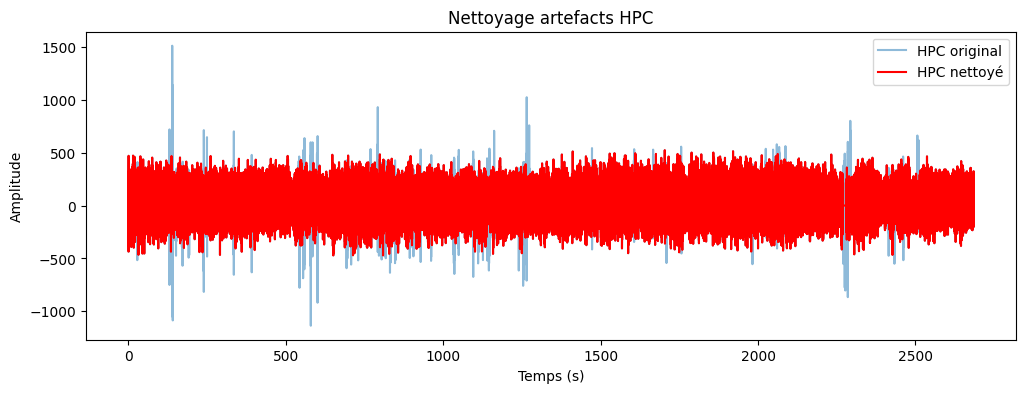

In [6]:
amp_thresh = (5, 5)         
time_win_thresh = (2, 0.1) 
fs = 2500                   

#REMOVE ARTEFACTS
hpc_clean, hpc_artifacts, time_hpc = removeArtefacts(signal_HPC, fs, amp_thresh, time_win_thresh)

plt.figure(figsize=(12,4))
plt.plot(time_hpc, signal_HPC, label="HPC original", alpha=0.5)
plt.plot(time_hpc, hpc_clean, label="HPC nettoyé", color="red")
plt.legend()
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.title("Nettoyage artefacts HPC")
plt.show()


# Down sampling

### Downsampling functions

In [7]:
from scipy.signal import resample_poly

def downsample_signal(sig, fs, target_fs):
    """
    Downsample un signal 1D de fs -> target_fs en appliquant anti-aliasing via resample_poly.
    Retourne (sig_down, new_fs, time_vector)
    """
    sig = np.asarray(sig)
    if sig.ndim != 1:
        raise ValueError("sig doit être un vecteur 1D")

    # calcul des facteurs up/down entiers pour resample_poly
    from math import gcd
    up = target_fs
    down = fs
    g = gcd(up, down)
    up //= g
    down //= g

    # resample_poly effectue filtrage anti-aliasing interne
    sig_down = resample_poly(sig, up, down)  # dtype float64 par défaut

    new_fs = int(round(fs * up / down))
    t_down = np.arange(sig_down.size) / new_fs
    return sig_down, new_fs, t_down

fs_orig = 2500
target_fs = 500

def compare_segment(orig_sig, down_sig, fs_orig, fs_down, start_s=0, dur_s=1.0):
    a0 = int(start_s * fs_orig)
    b0 = int((start_s + dur_s) * fs_orig)
    a1 = int(start_s * fs_down)
    b1 = int((start_s + dur_s) * fs_down)

    t0 = np.arange(a0, b0) / fs_orig
    t1 = np.arange(a1, b1) / fs_down

    plt.figure(figsize=(12,4))
    plt.plot(t0, orig_sig[a0:b0], alpha=0.6, label='original')
    plt.plot(t1, down_sig[a1:b1], linewidth=1.0, label='downsampled')
    plt.legend()
    plt.xlabel("Time (s)")
    plt.show()


Ancien quand il y avait un pb à 0

In [8]:

# hpc_500, fs_hpc_500, t_hpc_500 = downsample_signal(hpc_clean, fs_orig, target_fs)
# print("HPC:", signal_HPC.shape, "->", hpc_500.shape, " fs:", fs_hpc_500)


# compare_segment(signal_HPC, hpc_500, fs_orig, fs_hpc_500, start_s=22, dur_s=10)

# print("Portion hpc_500 suspecte:", hpc_500[27*fs_hpc_500:31*fs_hpc_500]) # problem at 0


## HPC downsampled + cleaned

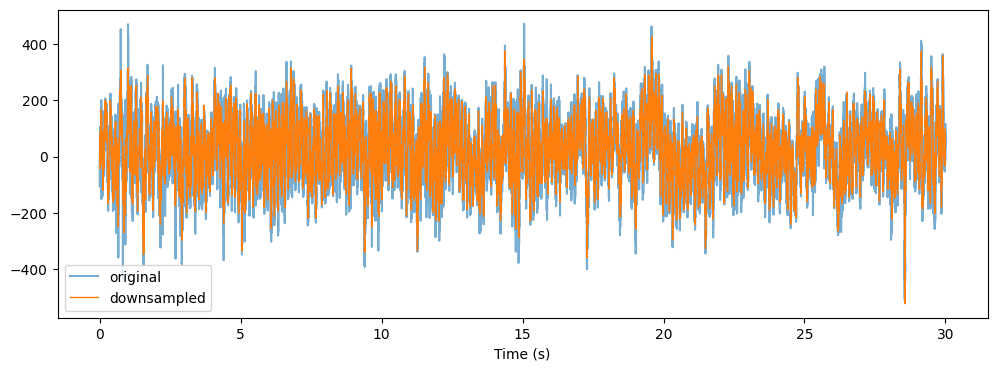

In [9]:
hpc_500, fs_hpc_500, t_hpc_500 = downsample_signal(signal_HPC, fs_orig, target_fs)

hpc_clean, hpc_artifacts, time_hpc = removeArtefacts(hpc_500, fs, amp_thresh, time_win_thresh)

compare_segment(signal_HPC, hpc_500, fs_orig, fs_hpc_500, start_s=0, dur_s=30)

## PFC downsampled + clean

L'ancien

In [10]:
# REMOVE ARTEFACTS
# pfc_clean, pfc_artifacts, time_pfc = removeArtefacts(signal_PFC, fs, amp_thresh, time_win_thresh)


#DOWNSAMPLING
# pfc_500, fs_pfc_500, t_pfc_500 = downsample_signal(pfc_clean, fs_orig, target_fs)

# compare_segment(signal_PFC, pfc_500, fs_orig, fs_pfc_500, start_s=10, dur_s=10)

Le bon 

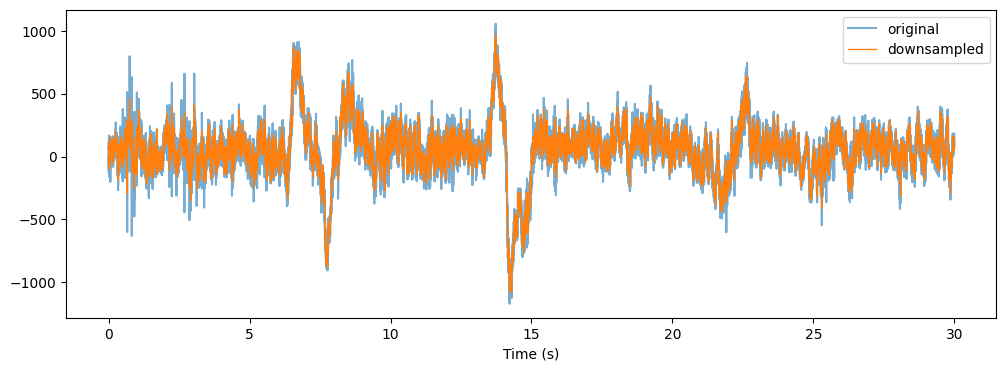

In [11]:
pfc_500, fs_pfc_500, t_pfc_500 = downsample_signal(signal_PFC, fs_orig, target_fs)

pfc_clean, pfc_artifacts, time_pfc = removeArtefacts(pfc_500, fs, amp_thresh, time_win_thresh)

compare_segment(signal_PFC, pfc_500, fs_orig, fs_pfc_500, start_s=0, dur_s=30)


# EMG

In [48]:
from scipy.ndimage import gaussian_filter1d

def compute_emg_buzsakiMethod(x, y, sig1, sig2, smoothWindow):
    """
    Computes the EMG signal using the Buzsaki method.

    Parameters:
        x (float): The target sampling of the EMG.
        y (float): The sampling frequency of the data.
        sig1 (numpy.ndarray): The signal of the first channel.
        sig2 (numpy.ndarray): The signal of the second channel.
        smoothWindow (int): The smoothing window for the EMG data.
    Returns:
        dict: A dictionary containing the computed EMG signal and related data.

    Note:
        This function filters the signal in the high frequency range to remove low-frequency physiologically correlated LFPs 
        (e.g., theta, delta, SPWs, etc.). It then computes the correlation between the two signals within different windows.
    """
    binScootS = 1 / x
    binScootSamps = round(y * binScootS)

    # 2. Filter the signal in the high frequency range
    # Filter first in high frequency band to remove low-freq physiologically
    # correlated LFPs (e.g., theta, delta, SPWs, etc.)
    maxfreqband = int(min(625, y / 2))
    xcorr_freqband = [275, 300, maxfreqband - 25, maxfreqband-0.0000001]  # Hz
    filteredSig1 = filtsig_in(sig1, y, xcorr_freqband)[0]
    filteredSig2 = filtsig_in(sig2, y, xcorr_freqband)[0]

    # 3. The relevant parameters important for further correlation analysis
    xcorr_window_samps = round(binScootS * y)
    xcorr_window_inds = np.arange(-xcorr_window_samps, xcorr_window_samps + 1)
    timestamps = np.arange(xcorr_window_inds[-1], sig1.shape[0] - xcorr_window_inds[-1], binScootSamps)
    numbins = len(timestamps)
    EMGCorr = np.zeros(numbins)
    c1, c2 = [], []
    binind, binindstart = -1, 0

    # Loop through different windows
    for i in range(numbins):
        binind += 1
        s1 = []
        s2 = []
        for k in (timestamps[i] + xcorr_window_inds):
          s1.append(filteredSig1[k])
          s2.append(filteredSig2[k])
        c1.append(s1)
        c2.append(s2)
        binindend = binind
        tmp = np.corrcoef(c1, c2)[0, 1]
        EMGCorr[binindstart:(binindend+1)] += tmp
        c1, c2 = [], []
        binindstart = binind + 1

    EMGCorr = EMGCorr/(2 * (2 - 1) / 2)
    EMGNorm = bz_NormToRange(EMGCorr, [0, 1])

    # Making the final structure of the EMG
    EMGFromLFP = {
        'timestamps': timestamps / y,
        'data': EMGCorr,
        'Norm': EMGNorm,
        'channels': 'HPC and PFC',
        'detectorName': 'bz_EMGFromLFP',
        'samplingFrequency': x
    }

    # Smoothing the EMG data
    dtEMG = 1 / EMGFromLFP['samplingFrequency']
    EMGFromLFP['smoothed'] = gaussian_filter1d(EMGFromLFP['data'], sigma=5)
    # Saving the data matrix
    return EMGFromLFP

def filtsig_in(sig, Fs, filtband_or_Filt):
    """
    Filters a signal using a specified filter or filter band.

    Parameters:
        sig (numpy.ndarray or list): The input signal to be filtered.
        Fs (float): The sampling frequency of the signal.
        filtband_or_Filt (list, numpy.ndarray, or tuple): The filter band or filter to be used. 
            If it's a list or numpy array, it should contain the pass and stop frequencies for the filter. 
            If it's a tuple, it should contain the filter coefficients.

    Returns:
        filt_sig (numpy.ndarray or list): The filtered signal.
        Filt (tuple): The filter used, represented as a tuple of coefficients.

    Note:
        This function uses a zero-phase digital filter to avoid phase distortion. 
        It applies the filter twice, once forward and once backwards.
    Created on Matlab by: Erik Schomburg, 2011
    """
    if isinstance(filtband_or_Filt, (list, np.ndarray)):
        b, a = iirdesign(wp=[filtband_or_Filt[1], filtband_or_Filt[2]], ws=[filtband_or_Filt[0], filtband_or_Filt[3]], gpass=1, gstop=60, fs=Fs)
        Filt = (b, a)
    else:
        Filt = filtband_or_Filt

    if sig is not None:
        if isinstance(sig, list):
            filt_sig = [filtfilt(Filt[0], Filt[1], s) for s in sig]
        elif sig.ndim > 1:
            filt_sig = np.array([filtfilt(Filt[0], Filt[1], s) for s in sig.T]).T
        else:
            filt_sig = filtfilt(Filt[0], Filt[1], sig)
    else:
        filt_sig = []

    return filt_sig, Filt

def bz_NormToRange(data, newrange):
    """
    Normalizes the input data to a specified range.

    Parameters:
        data (numpy.ndarray): The input data to be normalized.
        newrange (tuple): A tuple of two elements representing the new range (min, max) to which the data should be normalized.

    Returns:
        numpy.ndarray: The normalized data.
    """

    a, b = newrange
    x = data.copy()
    xmin, xmax = x.min(), x.max()
    return a + (x - xmin) * (b - a) / (xmax - xmin)

In [49]:
emg_result = compute_emg_buzsakiMethod(
    x=500,             # fréquence finale Échantillonnage EMG
    y=2500,            # fréquence initiale des signaux
    sig1=hpc_clean,    # signal 1
    sig2=pfc_clean,    # signal 2
    smoothWindow=201    # taille de la fenêtre de lissage, par exemple 51
)


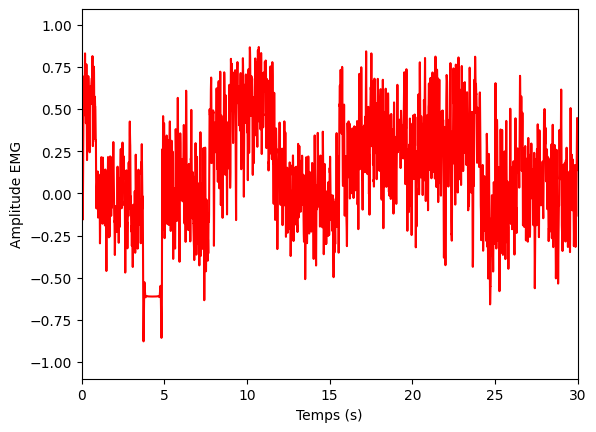

In [50]:
plt.plot(emg_result['timestamps'], emg_result['smoothed'], label ="EMG gaussian", color="red")
# plt.plot(emg_result['timestamps'], emg_result['data'], label="EMG brut", color = "green")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude EMG")
plt.xlim(0, 30)
plt.show()


In [34]:
emg_dict = compute_emg_buzsakiMethod(
    x=100,             # fréquence cible du signal EMG proxy (100 Hz recommandé)
    y=2500,              # fréquence d’échantillonnage de tes données brutes
    sig1=hpc_500,   # canal hippocampe
    sig2=pfc_500,   # canal préfrontal
    smoothWindow=11   # fenêtre de lissage 
)


## SMOOTH + ARTE 

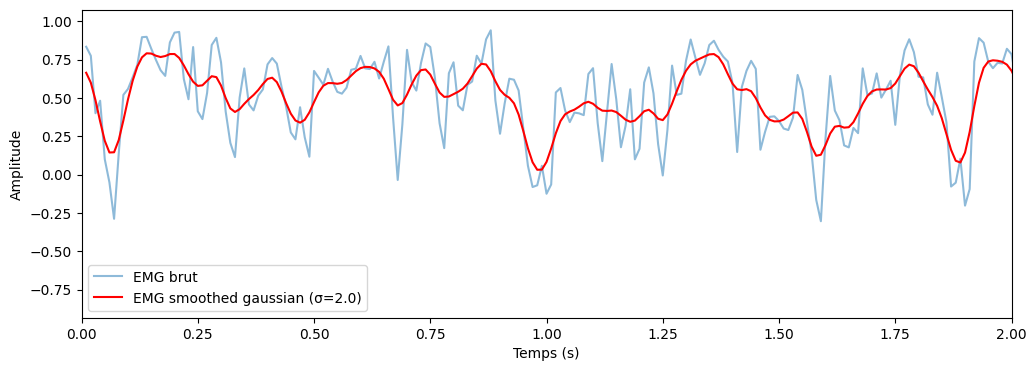

In [38]:
from scipy.ndimage import gaussian_filter1d

signal_EMG = emg_dict["data"]
time_EMG = emg_dict["timestamps"]

fs = 500  # Hz, fréquence d’échantillonnage du EMG proxy

win_sec = 10
sigma = 2
signal_EMG_smooth = gaussian_filter1d(signal_EMG, sigma=sigma)

plt.figure(figsize=(12,4))
plt.plot(time_EMG, signal_EMG, label="EMG brut", alpha=0.5)
plt.plot(time_EMG, signal_EMG_smooth, label=f"EMG smoothed gaussian (σ={sigma:.1f})", color="red")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim(0, 2) 
plt.show()

In [32]:
from scipy.ndimage import gaussian_filter1d

emg = hpc_clean - pfc_clean 

# Application du lissage gaussien
emg_smooth = gaussian_filter1d(emg, sigma=1)  # Le paramètre sigma ajuste le niveau de lissage


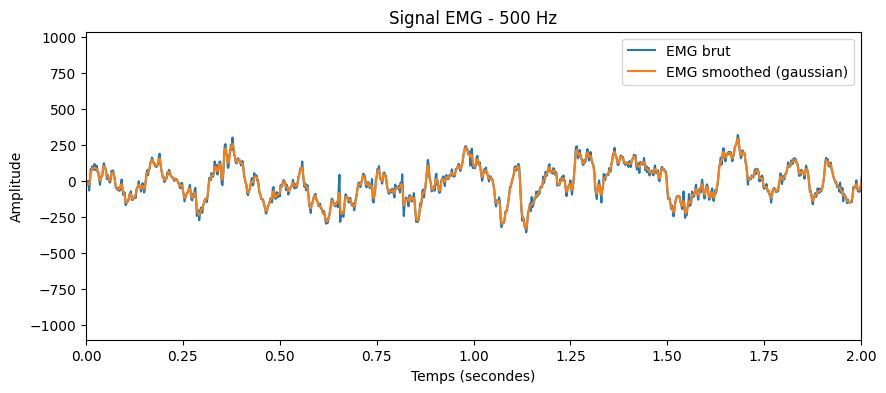

In [ ]:
# emg et emg_smooth sont tes signaux EMG, avec sampling_rate = 500
sampling_rate = 500
time = np.arange(len(emg)) / sampling_rate

plt.figure(figsize=(10, 4))
plt.plot(time, emg, label="EMG brut")
plt.plot(time, emg_smooth, label="EMG smoothed (gaussian)")
plt.xlabel("Time (second)")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Signal EMG - 500 Hz")
plt.xlim(0, 2) 
plt.show()
